# Step-by-step BCDI analysis 

## Table of contents
1. [Introduction](#introduction)
2. [Preprocessing](#preprocessing)
    1. [Loading the data](#loading)
    2. [Cropping the data](#cropping)
    3. [Cleaning the data](#cleaning)
3. [Phasing](#phasing)
    1. [Initialisation](#initialisation)
    2. [Running the phase retrieval](#running)
    3. [Phasing result analysis](#phasing_result_analysis)
4. [Orthogonalisation of the reconstructed data](#orthogonalisation)
    1. [Define the geometry associated to the beamline](#geometry)
    2. [Convention conversion](#convention)
5. [Extracting quantitative structural properties](#properties)
6. [Plotting](#plotting)
7. [Saving](#saving)

### Introduction <a name="introduction"></a>

This notebook provides a step-by-step guide for users who intend to analyse their BCDI data. Another notebook is available, but requires knowledge of various ***cdiutils*** parameters. To further automate the data processing procedure, scripts can be used to process data faster.

In this notebook, some code blocks are commented out. These correspond to optional plots/prints that you can check out for sanity verification.

**Notes:**
* In the following sections, some utility functions are used to display data when plotting requires more than one or two subplots. These functions do not perform any complex operations; they are just convenient ways to plot the data and simplify the code. If you want to check how the functions behave:
    * For the function parameters: use ```function_name?```
    * For the function source code: use ```function_name??```


import librairies:

In [14]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
import numpy as np
import os

import cdiutils

# update the matplotlib parameters 
cdiutils.plot.update_plot_params()

### Preprocessing <a name="preprocessing"></a>
#### Loading the data <a name="loading"></a>



Inspect the data layering system

In [10]:
experiment_path = ""  # the path to the /RAW_DATA dir of the experiment
# Ex: path = "/data/visitor/<experiment_name>/id01/<date>/RAW_DATA/"
!tree -L 1 {experiment_path}

.
├── analyse_bcdi_data.ipynb
└── step_by_step_bcdi_analysis.ipynb

0 directories, 2 files


Shape of the detector data is: (91, 516, 516)


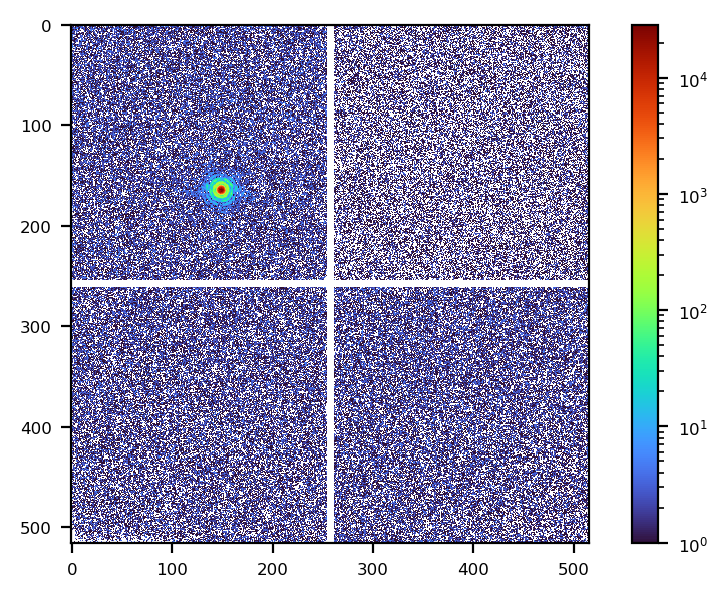

In [5]:
experiment_name = ""  # Required
experiment_file_path = f"{experiment_path}/{experiment_name}_id01.h5"

bliss_sample_name = ""  # Required
bliss_dataset_name = ""  # Required
scan = None  # Required

sample_name = f"{bliss_sample_name}_{bliss_dataset_name}"


loader = cdiutils.load.BlissLoader(
    experiment_file_path=experiment_file_path,
    sample_name=sample_name,
    detector_name="mpxgaas"  # Required
)
data = loader.load_detector_data(scan)

print(f"Shape of the detector data is: {data.shape}")
plt.figure(layout="tight")
plt.imshow(data[data.shape[0]//2], norm=LogNorm()); plt.colorbar(); plt.show()

Inspect the detector data with an interactive slider plot

In [15]:
cdiutils.plot.Plotter(data, plot="2D")

#### Cropping the Data <a name="cropping"></a>
Find the Bragg Peak position

Chain centering:
	- max: (46, 164, 149), value: 29649
	- com: (45, 164, 149), value: 28581


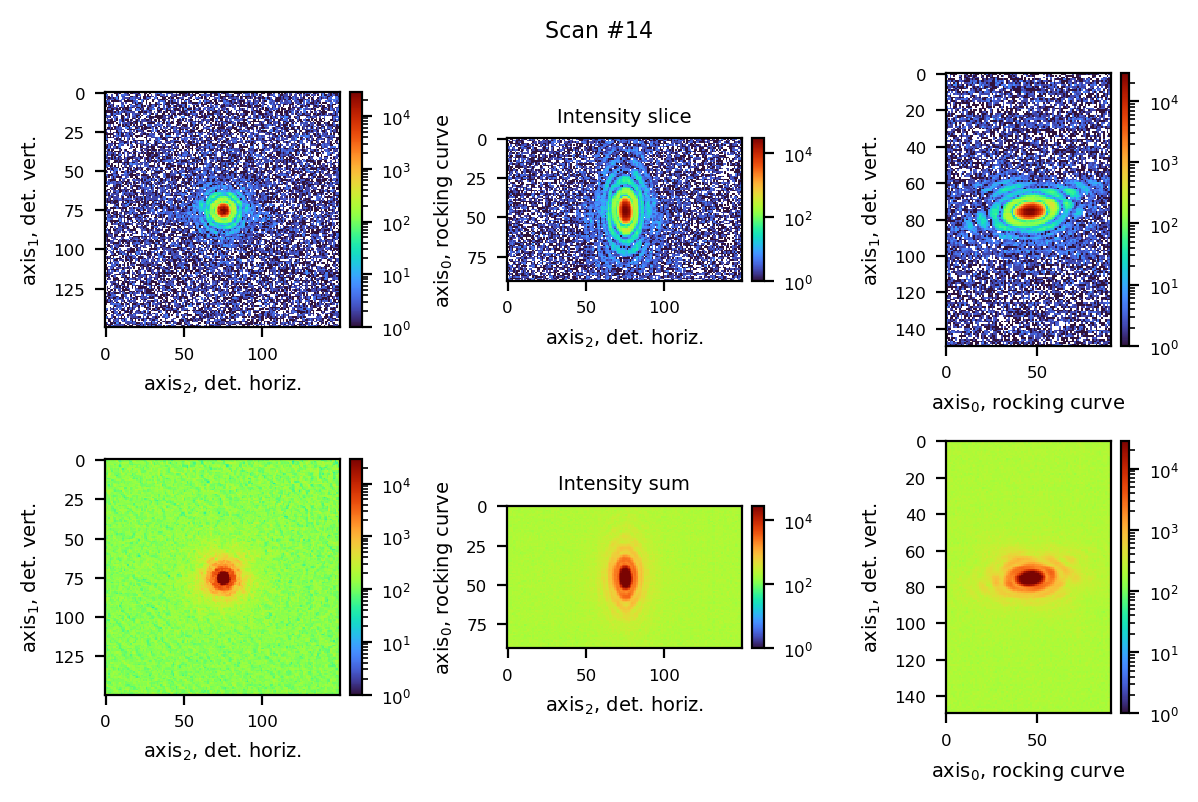

In [12]:
# data.shape[0] represents the number of frames in the rocking curve
output_shape = [data.shape[0], 150, 150]

# Crop the data according to specified methods. 'methods' can be a list
# of strings such as "com" or "max", or it can be a tuple specifying the
# reference detector pixel. The list can be as long as needed. Note that
# if there are hot pixels, "max" or "com" might not work effectively.
(
    cropped_data,  # the output cropped data
    det_ref,  # the detector reference voxel in the full detector frame
    cropped_det_ref,  # the detector reference voxel in the cropped detector frame
    roi  # the region of interest (ROI) used to crop the data
) = cdiutils.utils.CroppingHandler.chain_centering(
    data,
    methods=["max", "com"],  # the list of methods used sequentially
    output_shape=output_shape,  # the output shape you want to work with
    verbose=True  # whether to print logs during the reference voxel search
)

# Plot the cropped detector data
loader.plot_detector_data(cropped_data, f"Scan #{scan}", equal_limits=False)

### Cleaning the Data  <a name="cleaning"></a>

In this section, we will clean the data to improve its quality for analysis.

* Hot pixels can be removed using a median filter-based function (`cdiutils.utils.hot_pixel_filter`).
* Hot pixels can also be removed manually. For this, you can enable interactive plotting with `%matplotlib ipympl` and switch back to `%matplotlib inline` afterwards.
* Use a flat field to improve data quality.
* Remove background if fluorescence is expected.

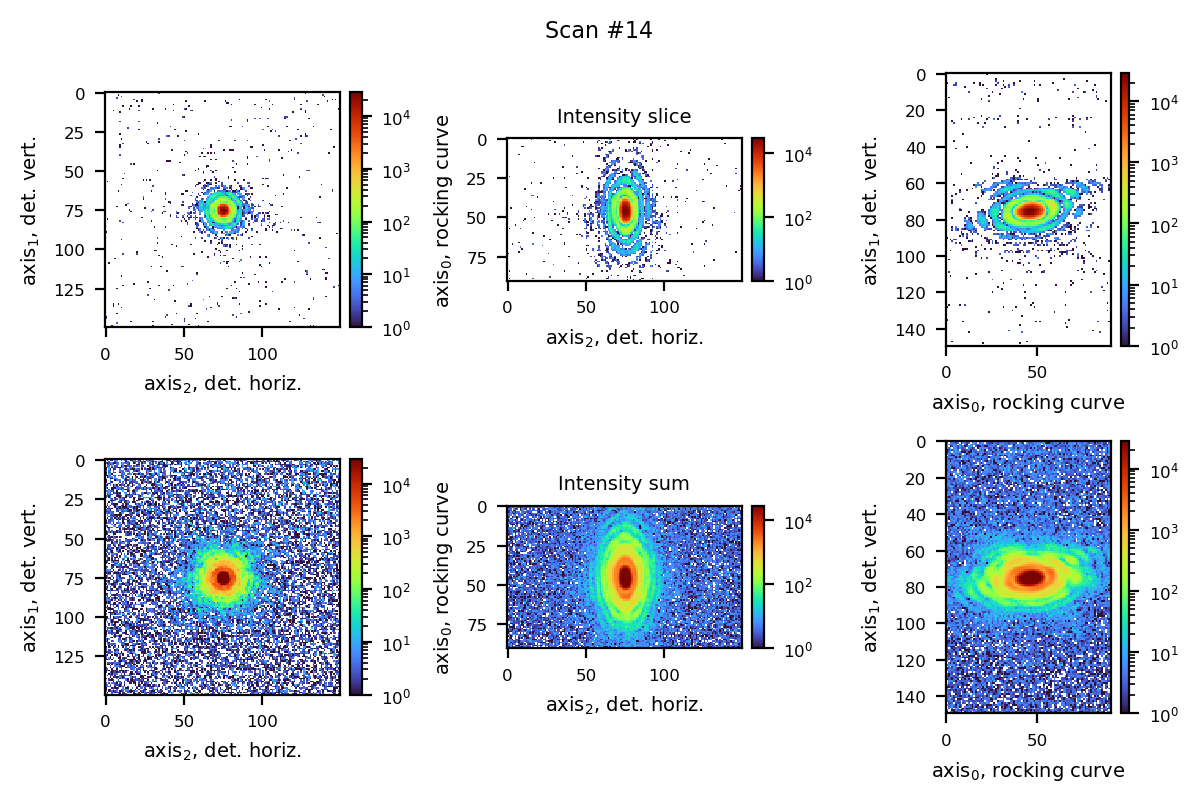

In [13]:
# If you have a flat field for the detector (at the correct energy), load and apply it.
# flat_field_path = ""

# with np.load(flat_field_path) as file:
#     flat_field = file["arr_0"][
#         cdiutils.utils.CroppingHandler.roi_list_to_slices(roi[2:])
#     ]
# cleaned_data = cropped_data * flat_field

# Remove hot pixels using a median filter-based function
cleaned_data, hot_pixel_mask = cdiutils.utils.hot_pixel_filter(cropped_data)

# If you intend to remove background noise (e.g., fluorescence), set the
# background level
background_level = 4
cleaned_data = np.where(
    cleaned_data - background_level > 0,
    cleaned_data - background_level, 0
)

# Plot the cleaned detector data
loader.plot_detector_data(cleaned_data, f"Scan #{scan}")

Load the mask with the correct shape

In [ ]:
mask = cdiutils.load.BlissLoader.get_mask(
    detector_name="mpxgaas",
    channel=cleaned_data.shape[0]
)[cdiutils.utils.CroppingHandler.roi_list_to_slices(roi)]
# mask *= hot_pixel_mask
loader.plot_detector_data(mask, f"Mask, scan #{scan}", norm=Normalize())


### Phasing <a name="phasing"></a>

This part requires PyNX package.

#### Initialisation <a name="initialisation"></a>

In [ ]:
# Initiliase the PyNXPhaser. It is wrapper to embed and initialise PyNX
# quickly. iobs (observed intensity) and mask are required. The
# parameters (params) are optional, since most of them have a default
# value.
phaser = cdiutils.process.PyNXPhaser(
    iobs=cleaned_data,
    mask=mask,
    params={
        "support_update": 50,
        "support_update": "0.15, 0.35",
        "show_cdi": 0,
        # "rebin": "1, 1, 1"
    }
)

# Initialise the CDI object. Support, or former cdi objects can be
# provided.
phaser.init_cdi(
    # support=good_support,  # if you want to start from a known support
)

# Plot the first guess.
phaser.plot_cdi(phaser.cdi)

#### Running the phase retrieval  <a name="running"></a>

In [ ]:
# Define the recipe you'd like to run.
recipe = "HIO**400, RAAR**500, ER**200"
phaser.run_multiple_instances(run_nb=5, recipe=recipe)

# The genetic phasing requires smaller recipes.
# recipe = "HIO**50, RAAR**60, ER**40"
# phaser.genetic_phasing(
#     run_nb=5, genetic_pass_nb=10, recipe, selection_method="mean_to_max"
# )

Plot the final result. This is just a first taste, you will be able to check out the reconstructions into more details right after. 

In [ ]:
for i, cdi in enumerate(phaser.cdi_list):
    phaser.plot_cdi(cdi, title=f"Run {i+1:04d}")

This cell is if you want to select a specific good run and start the phasing again from it.

In [ ]:
# good_run = 3

# good_support = phaser.cdi_list[good_run -1].get_support(shift=True)

#### Phasing results analysis <a name="phasing_result_analysis"></a>
The `cdiutils.process.PhasingResultAnalyser` class provides utility methods for analysing phase retrieval results.

The method `cdiutils.process.PhasingResultAnalyser.analyse_phasing_results` sorts the results based on the provided `sorting_criterion`, which can be:

* ```mean_to_max```: The difference between the mean of the Gaussian fitting of the amplitude histogram and the maximum value of the amplitude. A smaller difference indicates more homogeneous amplitude in the reconstruction.
* the ```sharpness```: The sum of the amplitude within the support raised to the power of 4. For reconstructions with similar support, lower values indicate greater amplitude homogeneity.
* ```std```: The standard deviation of the amplitude.
* ```llk```: The log-likelihood of the reconstruction.
* ```llkf```: The free log-likelihood of the reconstruction.


In [ ]:
analyser = cdiutils.process.PhasingResultAnalyser(cdi_results=phaser.cdi_list)

analyser.analyse_phasing_results(
    sorting_criterion = "mean_to_max"
    # plot_phasing_results=False,  # Defaults to True
    # plot_phase=True,  # Defaults to False
)

#### Select the Best Candidates and Run Mode Decomposition

In this cell, you have two options for selecting reconstructions:
- Manually select the ```best_runs```: Create a list of integers corresponding to the run digit numbers based on your visual analysis of the previous outputs.
- Automatically select the `nb_of_best_sorted_runs` (an integer) best runs using the `sorting_criterion` from the previous cell.

After selecting the runs, a mode decomposition is performed to obtain the 'principal mode' of the chosen runs. This process is somewhat similar to Principal Component Analysis (PCA).

In [ ]:
analyser.select_best_candidates(
    # best_runs=[2, 5]
    nb_of_best_sorted_runs=3,
)
print(
    f"The best candidates selected are: {analyser.best_candidates}."
)
mode = analyser.mode_decomposition()

#### Check the Amplitude Distribution
In this section, we check the amplitude distribution using the `cdiutils.utils.find_isosurface` function. Here's how it works:

- The function estimates an isosurface based on the analysis of the amplitude histogram.

- Assuming the right part of the histogram follows a Gaussian distribution, the isosurface is defined as $\mu - 3\sigma$, where $\mu$ and $\sigma$ represent the mean and standard deviation of the Gaussian density estimate.

- Keep in mind that the computation may not be perfectly stable, but the resulting plot can guide you toward a relevant isosurface.

In [ ]:
isosurface, _ = cdiutils.utils.find_isosurface(np.abs(mode), plot=True)

#### Define the Support Array and Calculate Oversampling Ratio

In this part of the code, we perform the following steps:

1. Define a `support` array that corresponds to the morphology of the object.
2. Calculate the oversampling ratio in each direction.
3. This oversampling information can be useful for re-phasing the data using the `rebin` parameter in PyNX.

In [ ]:
# isosurface = 0.45
support = cdiutils.utils.make_support(np.abs(mode), isosurface=isosurface)

ratios = cdiutils.utils.get_oversampling_ratios(support)
print(
    "[INFO] The oversampling ratios in each direction are "
    + ", ".join(
        [f"axis{i}: {ratios[i]:.1f}" for i in range(len(ratios))]
    )
    + ".\nIf low-strain crystal, you can set PyNX 'rebin' parameter to "
            "(" + ", ".join([f"{r//2}" for r in ratios]) + ")"
)

##### Plot the amplitude and phase of our final object (generated using our best reconstructions)

In [ ]:
figure, axes = plt.subplots(2, 3, layout="tight", figsize=(6, 4))

slices = cdiutils.utils.get_centred_slices(mode.shape)
for i in range(3):
    amp_img = axes[0, i].imshow(np.abs(mode)[slices[i]])
    phase_img = axes[1, i].imshow(
        np.angle(mode)[slices[i]], cmap="cet_CET_C9s_r"
    )

    for ax in (axes[0, i], axes[1, i]):
        cdiutils.plot.add_colorbar(ax, ax.images[0])
        limits = cdiutils.plot.x_y_lim_from_support(support[slices[i]])
        ax.set_xlim(limits[0])
        ax.set_ylim(limits[1])


### Orthogonalization of the Reconstructed Data <a name="orthogonalisation"></a>
(Transforming from the detector frame to the XU/CXI frame. See details below.)

This part involves:
- Retrieving the motor positions from the data file.
- Building the reciprocal space grid.
- Calculating the transformation matrices to map data from the detector frame to the lab (XU/CXI) frame.


In [ ]:
angles = loader.load_motor_positions(scan)
energy = loader.load_energy(scan)  # or define it manually.

#### Initialize the Reciprocal Space (Q-space) Grid Associated with the Detector Data

To correctly compute the grid, the detector calibration parameters (`det_calib_parameters`) are required. In particular, the following parameters are mandatory:
- Direct beam detector pixel position: `cch1` (vertical) and `cch2` (horizontal).
- Pixel size: `pwidth1` and `pwidth2`.
- Sample-to-detector distance: `distance`.

Other parameters allow for more accurate computation.


In [ ]:
det_calib_parameters = {
    "cch1": 56.074854967362114, # direct beam position vertical,
    "cch2": 118.36821297645119, # horizontal
    "pwidth1": 5.5e-05,  # detector pixel size in m
    "pwidth2": 5.5e-05,  # detector pixel size in m
    "distance": 0.953935828966216,  # sample to detector distance in m
    "tiltazimuth": 177.12335779627824,
    "tilt": 5.231672854863918,
    "detrot": -0.6923076923076923,
    "outerangle_offset": 0.0
}

#### Define the geometry associated to the beamline <a name="geometry"></a>

To check the geometry:
```
print(
    geometry.sample_circles,
    geometry.sample_circles,
    geometry.detector_horizontal_orientation,
    geometry.detector_vertical_orientation,
    geometry.beam_direction
)
```

In [ ]:
# Load the appropriate geometry
geometry = cdiutils.Geometry.from_setup("ID01")

# Initialise the space converter
converter = cdiutils.SpaceConverter(geometry, energy=energy)

# The Q space area is initialised only for the selected roi used
# beforehand to crop the data
converter.init_q_space_area(roi[2:], det_calib_parameters)
converter.set_q_space_area(**angles)

#### Check Whether the Q-space Gridding Has Worked Properly

To assess this, we'll need information about the Bragg reflection that was probed and the lattice parameter of the material.


In [ ]:
# What Bragg reflection did you measure?
hkl = [1, 1, 1]

In [ ]:
# Reminder: cropped_det_ref is the pixel reference chosen at the beginning. 
# It is the very center of the cropped data.
q_lab_ref = converter.index_det_to_q_lab(cropped_det_ref)
dspacing_ref = converter.dspacing(q_lab_ref)
lattice_parameter_ref = converter.lattice_parameter(q_lab_ref, hkl)
print(
    f"The d-spacing and 'effective' lattice parameter are respectively "
    f"{dspacing_ref:.4f} and {lattice_parameter_ref:.4f} angstroms.\n"
    "Is that what you expect?! -> If not, the detector calibration might "
    "be wrong."
)

#### Initialise the interpolators in both reciprocal and direct spaces.

In [ ]:
converter.init_interpolator(
    cleaned_data,
    output_shape,
    space="both",
    verbose=True
)

Note that this voxel size corresponds to the one calculated from the extent in reciprocal space. It can be changed afterwards if required.

In [ ]:
# This is the orthogonalised intensity
ortho_intensity = converter.orthogonalize_to_q_lab(cleaned_data)

# This is the regular Q-space grid
qx, qy, qz = converter.get_q_lab_regular_grid()

##### Plot the intensity in the orthogonal Q-space.

In [ ]:
q_spacing = [q[1] - q[0] for q in (qx, qy, qz)]
q_centre = (qx.mean(), qy.mean(), qz.mean())

figure, axes = cdiutils.plot.slice.plot_volume_slices(
    ortho_intensity,
    voxel_size=q_spacing,
    data_centre=q_centre,
    norm=LogNorm(1),
    convention="xu"
)
cdiutils.plot.add_labels(axes, space="rcp", convention="xu")
figure.suptitle("Orthogonalised intensity in the Q-lab frame")

### Orthogonalisation in Direct Space
The voxel size can be changed here (must be a float, tuple, list, or np.ndarray in nm). If not specified, the previously determined voxel size will be used.


In [ ]:
voxel_size = converter.direct_lab_interpolator.target_voxel_size
print(f"The target voxel size is: {voxel_size} nm.")

ortho_obj = converter.orthogonalize_to_direct_lab(
    mode,
    direct_space_voxel_size=voxel_size
)

In [ ]:
isosurface, _ = cdiutils.utils.find_isosurface(np.abs(ortho_obj), plot=True)

In [ ]:
# isosurface = 0.52
ortho_support = cdiutils.utils.make_support(
    np.abs(ortho_obj),
    isosurface=isosurface
)

In [ ]:
figures = {}
axes = {}

figures["amp"], axes["amp"] = cdiutils.plot.slice.plot_volume_slices(
    np.abs(ortho_obj),
    support=ortho_support,
    voxel_size=voxel_size,
    data_centre=(0, 0, 0),
    convention="xu",
)
figures["phase"], axes["phase"] = cdiutils.plot.slice.plot_volume_slices(
    np.angle(ortho_obj) * ortho_support,
    support=ortho_support,
    data_centre=(0, 0, 0),
    voxel_size=voxel_size,
    cmap="cet_CET_C9s_r",
    convention="xu",
    vmin=-np.pi,
    vmax=np.pi
)
cdiutils.plot.add_labels(axes["amp"], space="direct", convention="xu")
cdiutils.plot.add_labels(axes["phase"], space="direct", convention="xu")

figures["amp"].suptitle("Amplitude")
figures["phase"].suptitle("Phase")

### Convention Conversion <a name="convention"></a>

In the community, the CXI convention (https://cxidb.org/cxi.html) is often used. Therefore, *cdiutils* offers functions to transition from the *xrayutilities* convention (XU) to the CXI convention.

* In the XU convention:
    * Data are stored in the following way: $[\text{axis}_{0} = x_{\text{XU}}, \text{axis}_{1} = y_{\text{XU}}, \text{axis}_{2} = z_{\text{XU}}]$
    * $x_{\text{XU}}$: pointing away from the light source
    * $y_{\text{XU}}$: outboard
    * $z_{\text{XU}}$: vertical up

* In the CXI convention:
    * Data are stored in the following way: $[\text{axis}_{0} = z_{\text{CXI}}, \text{axis}_{1} = y_{\text{CXI}}, \text{axis}_{2} = x_{\text{CXI}}]$
    * $x_{\text{CXI}}$: horizontal, completing the right-handed system
    * $y_{\text{CXI}}$: vertical up
    * $z_{\text{CXI}}$: pointing away from the light source

![XU_and_CXI](https://github.com/clatlan/cdiutils/assets/38456566/5db91309-0735-4910-9090-5299666f6994)


In [ ]:
cxi_ortho_obj = converter.xu_to_cxi(ortho_obj)
cxi_ortho_support = converter.xu_to_cxi(ortho_support)
cxi_voxel_size = converter.xu_to_cxi(voxel_size)

In [ ]:
figures = {}
axes = {}

figures["amp"], axes["amp"] = cdiutils.plot.slice.plot_volume_slices(
    np.abs(cxi_ortho_obj),
    support=cxi_ortho_support,
    voxel_size=cxi_voxel_size,
    data_centre=(0, 0, 0),
)
figures["phase"], axes["phase"] = cdiutils.plot.slice.plot_volume_slices(
    np.angle(cxi_ortho_obj) * cxi_ortho_support,
    support=ortho_support,
    data_centre=(0, 0, 0),
    voxel_size=cxi_voxel_size,
    cmap="cet_CET_C9s_r",
    vmin=-np.pi,
    vmax=np.pi
)
cdiutils.plot.add_labels(axes["amp"])
cdiutils.plot.add_labels(axes["phase"])

figures["amp"].suptitle("Amplitude")
figures["phase"].suptitle("Phase")

### Extracting the Quantitative Structural Properties <a name="properties"></a>

Here we are going to use the `PostProcessor` class, which provides a variety of static methods, including:

- `flip_reconstruction`: Needed if you determine that you have the complex conjugate solution.
- `apodize`: Required to avoid high-frequency artifacts. It cuts the reciprocal space signal with a 3D window. This window can be "blackman", "hamming", "hann", "blackmanharris", "gaussian", and many others.
- `unwrap_phase`: Unwraps the phase for the voxels contained within the given support. It uses the `skimage.restoration.unwrap_phase` function.
- `remove_phase_ramp`: Removes the phase ramp of the object. It uses a linear regression model to find the ramp in 3D before removing it from the data.
- `phase_offset_to_zero`: Sets the phase offset to zero, i.e., the average phase over all voxels within the support will be zero.
- `get_displacement`: Computes the displacement using the phase and the position of the reciprocal space node considered as the center of the Bragg peak.
- `get_het_normal_strain`: Extracts the strain defined as the *heterogeneous normal* strain along the direction of the reciprocal space node reference. Two methods are possible:
    * The `numpy.gradient` traditional method. This method loses voxels at the surface.
    * The hybrid gradient that provides a second-order derivative for the bulk voxels and a first-order derivative for surface voxels. This allows for accurate computation of the strain at the surface.

Finally, there is a method that utilises all the others so you don't have to manage them individually: `get_structural_properties`. This method generates multiple quantities of interest, including:
* Displacement maps
* Strain maps
* d-spacing maps
* Lattice parameter maps


In [ ]:
# ortho_obj = cdiutils.process.PostProcessor.flip_reconstruction(ortho_obj)
cxi_ortho_obj = cdiutils.process.PostProcessor.apodize(cxi_ortho_obj, "blackman")

# Check up what this last line did with the following plot
figures = {}
axes = {}

figures["amp"], axes["amp"] = cdiutils.plot.slice.plot_volume_slices(
    np.abs(cxi_ortho_obj),
    support=cxi_ortho_support,
    voxel_size=cxi_voxel_size,
    data_centre=(0, 0, 0),
)
figures["phase"], axes["phase"] = cdiutils.plot.slice.plot_volume_slices(
    np.angle(cxi_ortho_obj) * cxi_ortho_support,
    support=cxi_ortho_support,
    data_centre=(0, 0, 0),
    voxel_size=cxi_voxel_size,
    cmap="cet_CET_C9s_r",
    vmin=-np.pi,
    vmax=np.pi
)
cdiutils.plot.add_labels(axes["amp"])
cdiutils.plot.add_labels(axes["phase"])

figures["amp"].suptitle("Amplitude")
figures["phase"].suptitle("Phase")


Now, extract the structural properties!

In [ ]:
struct_props = cdiutils.process.PostProcessor.get_structural_properties(
    cxi_ortho_obj,
    isosurface=0.4,
    g_vector=converter.xu_to_cxi(q_lab_ref),
    hkl=hkl,
    voxel_size=cxi_voxel_size,
    handle_defects=False  # this is whether you expect a defect.
)

for prop, value in struct_props.items():
    print(f"{prop}: ", end="")
    if isinstance(value, (np.ndarray)) and value.ndim > 1:
        print(f"3D array of shape: {value.shape}")
    elif isinstance(value, (list, tuple)):
        if isinstance(value[0], np.ndarray):
            print(f"tuple or list of length = {len(value)}")
        else:
            print(value)
    else:
        print(value)

Plot the data

In [ ]:
_, _, plot_configs = cdiutils.plot.set_plot_configs()
for prop in (
        "amplitude", "support", "phase",
        "displacement", "het_strain", "dspacing"
):
    figures[prop], axes[prop] = cdiutils.plot.slice.plot_volume_slices(
        struct_props[prop]*cdiutils.utils.zero_to_nan(struct_props["support"]),
        support=struct_props["support"],
        voxel_size=cxi_voxel_size,
        data_centre=(0, 0, 0),
        vmin=plot_configs[prop]["vmin"],
        vmax=plot_configs[prop]["vmax"],
        cmap=plot_configs[prop]["cmap"]
    )
    figures[prop].suptitle(prop)
    cdiutils.plot.add_labels(axes[prop])
    

A fancy summary plot

In [ ]:
to_be_plotted = {
    k: struct_props[k]
    for k in [
        "amplitude", "phase", "displacement", "het_strain", "lattice_parameter"
    ]
}

summary_fig = cdiutils.process.plot.summary_slice_plot(
    title=f"Summary figure, Scan #{scan}",
    support=struct_props["support"],
    dpi=200,
    voxel_size=cxi_voxel_size,
    isosurface=isosurface,
    det_reference_voxel=det_ref,
    averaged_dspacing=np.nanmean(struct_props["dspacing"]),
    averaged_lattice_parameter=np.nanmean(struct_props["lattice_parameter"]),
    **to_be_plotted
)

3D view of the strain

In [ ]:
fig = cdiutils.plot.volume.plot_3d_surface_projections(
    data=struct_props["het_strain"],
    support=struct_props["support"],
    voxel_size=cxi_voxel_size,
    cmap="cet_CET_D13",
    vmin=-np.nanmax(np.abs(struct_props["het_strain"])),
    vmax=np.nanmax(np.abs(struct_props["het_strain"])),
    cbar_title=r"Strain (%)",
    title=f"3D views of the strain, Scan #{scan}"
)

#### Save the data

In [ ]:
# Provide the path of the directory you want to save the data in
dump_dir = f"results/{sample_name}/S{scan}_step_by_step/" 

if os.path.isdir(dump_dir):
    print(
        "[INFO] Dump directory already exists, results will be saved in\n",
        dump_dir
    )
else:
    print(f"[INFO] Creating the dump directory at: {dump_dir}")
    os.makedirs(dump_dir, exist_ok=True)

to_save = {
    "isosurface": isosurface,
    "q_lab_reference": q_lab_ref,
    "dspacing_reference": dspacing_ref,
    "lattice_parameter_reference": lattice_parameter_ref
}

# Select the data you want to save
to_save = {
    "isosurface": isosurface,
    "q_lab_reference": q_lab_ref,
    "dspacing_reference": dspacing_ref,
    "lattice_parameter_reference": lattice_parameter_ref
}

to_save.update(struct_props)

# Save as .npz file
np.savez(f"{dump_dir}/S{scan}_structural_properties.npz", **to_save)

# Save as .vti file
# This is for 3D visualisation, so we do not need to save everything.
to_save_as_vti = {
    k: struct_props[k]
    for k in [
        "amplitude", "support", "phase", "displacement", "het_strain",
        "het_strain_from_dspacing", "lattice_parameter", "numpy_het_strain",
        "dspacing"
    ]
}

# Also, we want to avoid nan values as they will mess up the visualisation.
# Therefore, nan value are replaced by average value of the quantity.
for k in (
        "het_strain", "het_strain_from_dspacing",
        "lattice_parameter", "dspacing"
):
    to_save_as_vti[k] = np.where(
        np.isnan(to_save_as_vti[k]),
        np.nanmean(to_save_as_vti[k]),
        to_save_as_vti[k]
    )


cdiutils.process.BcdiProcessor.save_to_vti(
    f"{dump_dir}/S{scan}_structural_properties.vti",
    voxel_size=voxel_size,
    cxi_convention=True,
    **to_save_as_vti
)

print("\n[INFO] data saved.")

#### Further cells to come...

Please send comments and suggestions or report any issues you've encountered to:
[clement.atlan@esrf.fr](mailto:clement.atlan@esrf.fr?subject=cdiutils)

Or raise issues on the dedicated [GitHub page](https://github.com/clatlan/cdiutils/issues).